### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
#imports
import scipy.io
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import obspy
import pywt
import pywt.data

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

### Load the trimmed data 

In [3]:
path = "/Users/ecem/Desktop/phonocardiogram/data/PV"
waves = np.load(path + "/PV_waves-10sec.npy", allow_pickle= True)

In [4]:
waves.shape

(8657, 40000)

## Let's look at wavelet decomposition for a signal piece

#### how our decomposition filter values look like

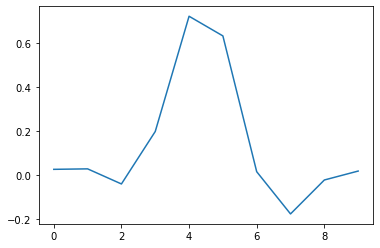

In [5]:
w = pywt.Wavelet('sym5')
plt.plot(w.dec_lo)
coeffs = pywt.wavedec(waves[0], w, level=6)

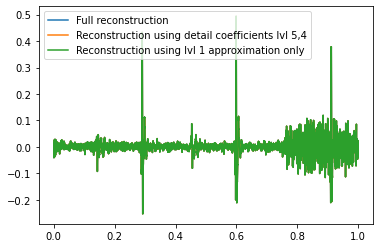

In [6]:
def reconstruction_plot(yyy, **kwargs):
    """Plot signal vector on x [0,1] independently of amount of values it contains."""
    plt.plot(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(pywt.waverec(coeffs, w)) # full reconstruction 
reconstruction_plot(pywt.waverec(coeffs[:-1] + [None] * 1, w)) # leaving out detail coefficients up to lvl 5
reconstruction_plot(pywt.waverec(coeffs[:-2] + [None] * 2, w)) # leaving out detail coefficients up to lvl 4
#reconstruction_plot(pywt.waverec(coeffs[:-3] + [None] * 3, w)) # leaving out detail coefficients up to lvl 3
#reconstruction_plot(pywt.waverec(coeffs[:-4] + [None] * 4, w)) # leaving out detail coefficients up to lvl 2
#reconstruction_plot(pywt.waverec(coeffs[:-5] + [None] * 5, w)) # leaving out detail coefficients up to lvl 1
#reconstruction_plot(pywt.waverec(coeffs[:-6] + [None] * 6, w)) # leaving out all detail coefficients = reconstruction using lvl1 approximation only
plt.legend(['Full reconstruction', 'Reconstruction using detail coefficients lvl 5,4', 'Reconstruction using lvl 1 approximation only'])

Amplitude of the coefficient corresponds to amplitude with which the wavelet occurs in the signal (y axis), and position of the coefficient corresponds to the time (x axis). 

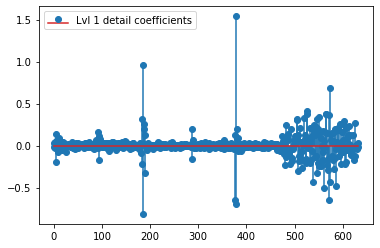

In [7]:
plt.stem(coeffs[1]); plt.legend(['Lvl 1 detail coefficients'])

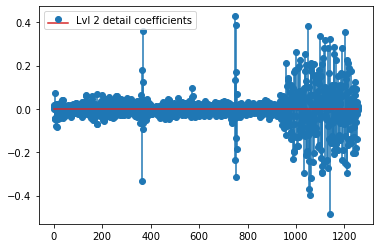

In [8]:
plt.stem(coeffs[2]); plt.legend(['Lvl 2 detail coefficients'])


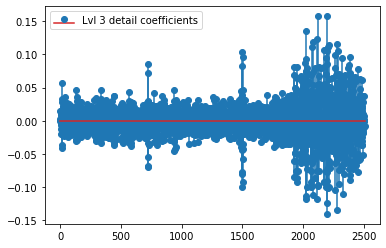

In [9]:
plt.stem(coeffs[3]); plt.legend(['Lvl 3 detail coefficients'])


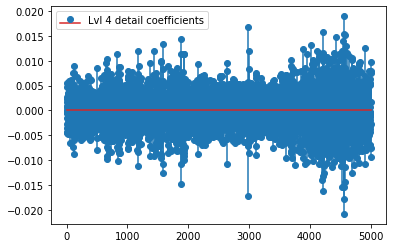

In [10]:
plt.stem(coeffs[4]); plt.legend(['Lvl 4 detail coefficients'])


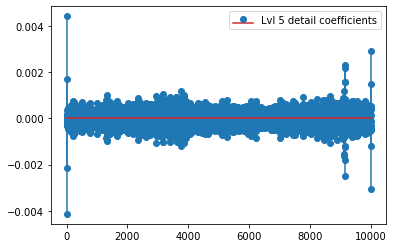

In [11]:
plt.stem(coeffs[5]); plt.legend(['Lvl 5 detail coefficients'])


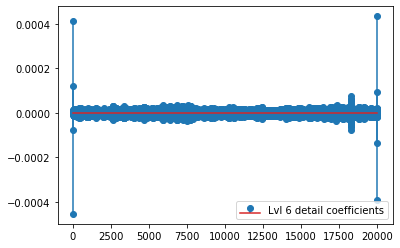

In [12]:
plt.stem(coeffs[6]); plt.legend(['Lvl 6 detail coefficients'])

In [13]:
# Reconstruction of signal using just lvl1 approximation
approx_lvl1 = pywt.waverec(coeffs[:-6] + [None] * 6, w)
# interpolate to original amount of samples (necessary due to numeric solution of transformation not yielding same amount of values)
approx_lvl1_interp = np.interp(x=np.arange(0, len(waves[0])), xp=np.linspace(0, 525, len(approx_lvl1)), fp=approx_lvl1)
x_without_lvl1approx = waves[0] - approx_lvl1_interp

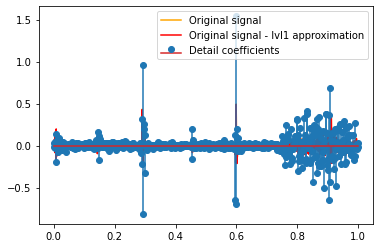

In [14]:
def reconstruction_stem(yyy, **kwargs):
    """Plot coefficient vector on x [0,1] independently of amount of values it contains."""
    plt.stem(np.linspace(0, 1, len(yyy)), yyy, **kwargs)

reconstruction_plot(waves[0], color='orange')
reconstruction_plot(x_without_lvl1approx, color='red')
reconstruction_stem(coeffs[1])
plt.legend(['Original signal', 'Original signal - lvl1 approximation', 'Detail coefficients'])

In [15]:
import pandas as pd

In [16]:
type(pywt.wavedec(waves[0], w, level=6))

list

In [17]:
coef = []
for i in range(len(waves)):
    coef.append(pywt.wavedec(waves[i], w, level=6))

In [18]:
for i in range(7):
    print(coef[0][i].shape)

(633,)
(633,)
(1258,)
(2508,)
(5007,)
(10006,)
(20004,)


### Level by level

In [20]:
def level_coef_extractor_3d(array, lvl = 0):
    array =np.array(array)
    
    lenn = array[0][lvl].shape[0] #633
    coef = np.ones(shape = (array.shape[0],lenn)) #8657, 633
    
    for i in range(array.shape[0]):
        coef[i,:] = array[i][lvl]
        
    return coef

In [21]:
def saver(array = 0, lvl = 0, dir_path = None, name = 'blank'):
    coefs = level_coef_extractor_3d(array, lvl)
    np.save(dir_path + "/"+ str(name) + "_lvl_"  + str(lvl), coefs, allow_pickle = True)
    del coefs

In [22]:
for i in range(7):
    saver(coef, i, path, 'wavelet-coef-PV')


In [23]:
waves_ = np.load(path+ "/wavelet-coef-PV_lvl_0.npy",  allow_pickle = True)

In [24]:
waves_.shape

(8657, 40000)

In [25]:
waves[0]

array([ 0.00735044,  0.00533181,  0.00282672, ..., -0.00221212,
       -0.00376666, -0.00525753], dtype=float32)

In [26]:
waves[10]

array([-0.1580997 , -0.148099  , -0.13387462, ..., -0.00195166,
       -0.00144917, -0.00099527], dtype=float32)

### Check whether each data saved correctly

In [27]:
def column_namer(level = 0, lenght = 48):
    x = []
    for i in range(lenght):
        x.append("lvl{0}_{1}".format(level, i))
    
    return x 

In [28]:
import pandas as pd

In [29]:
def dataframe_checker(path, name = "wavelet-coef-PV", df = pd.DataFrame(), level = 0):

    values  = []

    array = np.load(path + "/" + name + "_lvl_{}.npy".format(level), allow_pickle = True)
    columns = column_namer(level = level, lenght = array.shape[1])
    
    for i in range(array.shape[0]):
        values.append(array[i].tolist()) 

        medium = pd.DataFrame([values[i]], columns = columns)
        
        df = pd.concat([df, medium], axis = 0)
        
    
    return df

In [30]:
df = dataframe_checker(path,  "wavelet-coef-PV", level = 0 )
df

lvl0_0    lvl0_1    lvl0_2    lvl0_3    lvl0_4    lvl0_5    lvl0_6  \
0  -0.009131  0.060001  0.045081 -0.040817 -0.010380 -0.018948  0.096401   
0  -0.085896 -0.079618 -0.079558 -0.086438 -0.075344 -0.063147 -0.048006   
0   0.460946  0.501802  0.458874  0.306141 -0.136107 -0.027268 -0.123793   
0  -0.105055 -0.134510 -0.124946 -0.073736 -0.025758  0.014507  0.023268   
0  -0.110062 -0.145278 -0.133987 -0.053926  0.064311 -0.005887  0.118478   
..       ...       ...       ...       ...       ...       ...       ...   
0  -0.095173 -0.104167 -0.102963 -0.092771 -0.099883 -0.011227  0.053844   
0   0.003664  0.006208  0.006155  0.004259  0.010934  0.002211 -0.010648   
0  -1.170254 -1.168979 -1.151338 -1.069815 -0.741163 -0.195447  0.335939   
0  -0.041273 -0.042732 -0.043546 -0.047285 -0.069281 -0.105946 -0.153101   
0   0.008655  0.009593  0.008556  0.004110 -0.007721 -0.006033  0.012617   

      lvl0_7    lvl0_8    lvl0_9  ...  lvl0_623  lvl0_624  lvl0_625  lvl0_626  \
0  -0.001775  0.074502 -0.049553  ...  0.123539  0.027963  0.167890 -0.054516   
0  -0.033384  0.014231 -0.088771  ...  0.033930 -0.006715 -0.010344  0.041296   
0  -0.029290  0.256371 -0.047826  ... -0.041722 -0.119836  0.069906  0.023078   
0   0.018738  0.071060  0.010508  ... -0.195366 -0.142518  0.012305  0.125241   
0  -0.035711  0.002893  0.054282  ...  0.166787 -0.085369  0.052689  0.032874   
..       ...       ...       ...  ...       ...       ...       ...       ...   
0   0.056101  0.100651  0.128145  ... -0.023127  0.002894  0.023048  0.002612   
0  -0.032067 -0.033286 -0.051758  ...  0.451288  4.618891  3.431952 -1.108558   
0   0.272246  0.037884 -0.071980  ...  0.006397 -0.007747 -0.002004 -0.007766   
0  -0.181726 -0.421866 -0.265829  ... -0.049619 -0.011732 -0.003912 -0.024391   
0   0.012645  0.005573 -0.009343  ... -1.794892 -2.688511  1.071317  5.333283   

    lvl0_627  lvl0_628  lvl0_629  lvl0_630  lvl0_631  lvl0_632  
0  -0.102137  0.031467 -0.013963 -0.017467 -0.012491 -0.010586  
0   0.029276  0.031148  0.254345  0.226972  0.209473  0.201169  
0  -0.054041 -0.129180 -0.160773 -0.156230 -0.152166 -0.148496  
0   0.037615 -0.028133 -0.009117 -0.011301 -0.011323 -0.008094  
0  -0.085566 -0.143975 -0.332285 -0.298983 -0.288322 -0.285601  
..       ...       ...       ...       ...       ...       ...  
0   0.007012  0.013653  0.010178  0.011217  0.011051  0.010414  
0  -2.589208 -1.180551 -1.097435 -1.176941 -1.175622 -1.180183  
0  -0.016427 -0.033991 -0.035241 -0.033297 -0.033594 -0.034032  
0  -0.025359 -0.001753  0.032358  0.021045  0.021057  0.024315  
0   3.171625  0.048533 -0.163000  0.058866  0.057568  0.075562  

[8657 rows x 633 columns]

In [32]:
#df.to_csv(dir_path + '/wavelet_lvl_0.csv')